
Calibrate the model to the implied vol curve of options on SnP500 futures (sea data from
https://www.cmegroup.com/trading/equity-index/us-index/sandp-500_quotes_options.html?optionExpiration=H0#optionExpiration=H0&optionProductId=135&strikeRange=ATM)

a. Take options maturing in May 2020 (Let $T_1$ is option's maturity)
 (note that underlying futures may have different maturity).

b. Build implied vol curve for strikes around ATM level (plus/minus 10-15% from ATM at your choice). Take 7-8 strikes $K_i$ at most.

c. Calibrate the model to the curve by minimizing the weighted sum of squared deviations. Assign greater weights for strikes, which are closer to ATM level. Make sure, that model parameters take values, which makes sense. For example, since significant jumps are happening once in several years, $\lambda$ should be small.  


Take another set of options maturing any other date later than May 2020 ($T_2$ maturity).
Calibrate the model to fit implied curves for two maturities simultaneously.



In [0]:
import math
import matplotlib.pyplot as plt 
import numpy as np  # NumPy
import pandas as pd  # pandas
import cufflinks as cf  # Cufflinks
from scipy.integrate import quad
import configparser as cp
cf.set_config_file(offline=True)  # set the plotting mode to offline
from scipy import stats
from scipy.stats import norm
from math import factorial
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## 2.a)

We took options maturing in May 2020 from the cme website.

In [0]:
r = 0.001 

t = 16/252 #16 days until expiration
F = 2880

K = [2880, 2780, 2680, 2600, 2975, 3070, 3170]
C = [74.6, 145, 226.2, 296.7, 26.6, 5.5, 1.2]

op = {i: j for i,j in zip(C, K)}
op

{1.2: 3170,
 5.5: 3070,
 26.6: 2975,
 74.6: 2880,
 145: 2780,
 226.2: 2680,
 296.7: 2600}

In [0]:
def callf(r,t,F,K,vol):
  d1=1/(vol* np.sqrt(t)) * (np.log(F/K) + 0.5 * (vol ** 2) * t)
  d2=d1-vol * np.sqrt(t)
  c = np.exp(-r*t) * ( norm.cdf(d1) * F -  norm.cdf(d2) * K)
  return c

In [0]:
volat = {}

for i in op.items():

  call, strike = i[0], i[1]
  fnc = lambda volatility: callf(r, t, F, strike, volatility) - call
  volat[strike] = fsolve(fnc, 0.1)[0]  # hist vol as guess point
volat

{2600: 0.3641149257220977,
 2680: 0.33788102257222596,
 2780: 0.30208789211577897,
 2880: 0.25773918119533434,
 2975: 0.21426071213173173,
 3070: 0.18567864626811703,
 3170: 0.18963385574672242}

## 2.b)

Now let's build implied vol curve for strikes around ATM level.

No handles with labels found to put in legend.


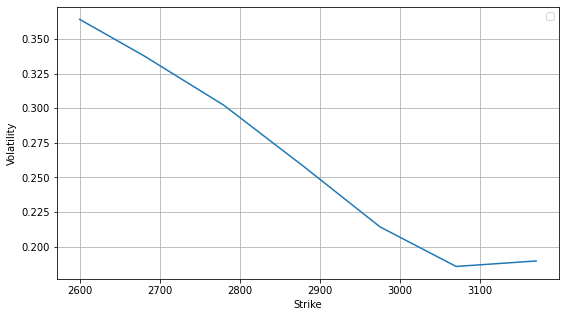

In [0]:
fields = ['STRIKE_PRC', 'CF_CLOSE', 'IMP_VOLT','WEIGHT', 'MATUR']
df = pd.DataFrame(columns = fields)
df = df.append({'STRIKE_PRC': 2600 , 'CF_CLOSE': 296.7 , 'IMP_VOLT': 0.364115, 'WEIGHT': 0.3, 'MATUR': 16}, ignore_index=True)
df = df.append({'STRIKE_PRC': 2680 , 'CF_CLOSE': 226.2 , 'IMP_VOLT': 0.337881, 'WEIGHT': 0.6, 'MATUR': 16}, ignore_index=True)
df = df.append({'STRIKE_PRC': 2780 , 'CF_CLOSE': 145 , 'IMP_VOLT': 0.302088, 'WEIGHT': 0.9, 'MATUR': 16}, ignore_index=True)
df = df.append({'STRIKE_PRC': 2880 , 'CF_CLOSE': 74.6 , 'IMP_VOLT': 0.257739, 'WEIGHT': 1, 'MATUR': 16}, ignore_index=True)
df = df.append({'STRIKE_PRC': 2975 , 'CF_CLOSE': 26.6 , 'IMP_VOLT': 0.214261, 'WEIGHT': 0.9, 'MATUR': 16}, ignore_index=True)
df = df.append({'STRIKE_PRC': 3070 , 'CF_CLOSE': 5.5 , 'IMP_VOLT': 0.185679, 'WEIGHT': 0.6, 'MATUR': 16}, ignore_index=True)
df = df.append({'STRIKE_PRC': 3170 , 'CF_CLOSE': 1.2 , 'IMP_VOLT': 0.189634, 'WEIGHT': 0.3, 'MATUR': 16}, ignore_index=True)
df

plt.figure(figsize = (9, 5))
sns.lineplot(x=df.STRIKE_PRC,y=df.IMP_VOLT)

plt.legend()
plt.xlabel('Strike')
plt.ylabel('Volatility')
plt.grid()
plt.show()

The graph above plots the implied volatilies at diffrent strike prices. For large K we can observe a an upwardsloping "leg".

In [0]:
df

,STRIKE_PRC,CF_CLOSE,IMP_VOLT,WEIGHT,MATUR
0,2600.0,296.7,0.364115,0.3,16.0
1,2680.0,226.2,0.337881,0.6,16.0
2,2780.0,145.0,0.302088,0.9,16.0
3,2880.0,74.6,0.257739,1.0,16.0
4,2975.0,26.6,0.214261,0.9,16.0
5,3070.0,5.5,0.185679,0.6,16.0
6,3170.0,1.2,0.189634,0.3,16.0


## 2.c)

Let's calibrate the model to the curve by minimizing the weighted sum of squared deviations. 



In [0]:
def call_futures(r, T, F, K, vol):
  d1 = 1/(np.sqrt(T)*vol)*(np.log(F/K) + r*T + 1/2*(vol**2)*T)
  d2 = d1 - vol*np.sqrt(T)
  callfut = F*norm.cdf(d1)-np.exp(-r*T)*K*norm.cdf(d2)
  return callfut

In [0]:
def voljump(T,j,sigma,s):
  voljmp=j*(s**2)/T+sigma**2
  return voljmp

In [0]:
def fjump(F,T,j,lmbda,m,s):
  k=np.exp(0.5*s**2+m)-1
  fjum=F*np.exp(j*(m+0.5*s**2)-lmbda*k*T)
  return fjum

In [0]:
def call_futures_jump(r,F,K,T,j,lmbda,m,s,sigma):
  fj=fjump(F,T,j,lmbda,m,s)
  volj=voljump(T,j,sigma,s)**0.5
  call_fut_jump=call_futures(r,T,fj,K,volj)
  return call_fut_jump


In [0]:
def M76_value_call_INT(F, K, T, r, sigma, lmbda, m, s):
  value=0
  for i in range(100):
    value+=np.exp(-lmbda*T)*((lmbda*T)**i)/math.factorial(i)*call_futures_jump(r,F,K,T,i,lmbda,m,s,sigma)
  return value

In [0]:
ind = 2880 #index
r = 0.001 #interest rate


Error function:

In [0]:
i = 0; min_RMSE = 100.
def M76_error_function(p0):
    global i, min_RMSE
    sigma, lamb, mu, delta = p0
    if sigma < 0.0 or delta < 0.0 or lamb < 0.0:
        return 500.0
    se = []
    for row, option in df.iterrows():
        T = option['MATUR'] / 252
        model_value = M76_value_call_INT(ind, option['STRIKE_PRC'], T,
                                         r, sigma, lamb, mu, delta)
        se.append(option['WEIGHT']*(sigma - option['IMP_VOLT']) ** 2)

    RMSE = math.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    if i % 100 == 0:
        print ('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (RMSE, min_RMSE))
    i += 1
    return RMSE

Global optimization:

In [0]:
%%time
import scipy.optimize as sop
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%6.3f' % x})
p0 = sop.brute(M76_error_function, ((0.10, 0.2, 0.025),
                   (0.10, 0.80, 0.10), (-0.40, 0.01, 0.10),
                   (0.00, 0.120, 0.02)), finish=None)

   0 | [ 0.100  0.100 -0.400  0.000] |   0.139 |   0.139
 100 | [ 0.100  0.400 -0.300  0.080] |   0.139 |   0.139
 200 | [ 0.100  0.700 -0.100  0.040] |   0.139 |   0.139
 300 | [ 0.125  0.400 -0.400  0.000] |   0.120 |   0.120
 400 | [ 0.125  0.700 -0.300  0.080] |   0.120 |   0.120
 500 | [ 0.150  0.300 -0.100  0.040] |   0.102 |   0.102
 600 | [ 0.150  0.700 -0.400  0.000] |   0.102 |   0.102
 700 | [ 0.175  0.300 -0.300  0.080] |   0.084 |   0.084
 800 | [ 0.175  0.600 -0.100  0.040] |   0.084 |   0.084
CPU times: user 2min 5s, sys: 281 ms, total: 2min 5s
Wall time: 2min 5s


Local optimization:

In [0]:
%%time
opt = sop.fmin(M76_error_function, p0, xtol=0.0000001,
                    ftol=0.0000001, maxiter=750, maxfun=1500)

 900 | [ 0.262  0.100 -0.285  0.000] |   0.047 |   0.047
1000 | [ 0.261  0.100 -0.283  0.000] |   0.047 |   0.047
Optimization terminated successfully.
         Current function value: 0.046542
         Iterations: 109
         Function evaluations: 204
CPU times: user 29.9 s, sys: 55.9 ms, total: 30 s
Wall time: 29.9 s


In [0]:
sigma, lamb, mu, delta = opt
df['MODEL_PRICE'] = 0.0
for row, option in df.iterrows():
    T = option['MATUR'] / 252
    df.loc[row, 'MODEL_PRICE'] = M76_value_call_INT(ind, option['STRIKE_PRC'],
                                T, r, sigma, lamb, mu, delta)
df['MATUR']=16

In [0]:
df

,STRIKE_PRC,CF_CLOSE,IMP_VOLT,WEIGHT,MATUR,MODEL_PRICE
0,2600.0,296.7,0.364115,0.3,16,287.257875
1,2680.0,226.2,0.337881,0.6,16,215.440642
2,2780.0,145.0,0.302088,0.9,16,137.295856
3,2880.0,74.6,0.257739,1.0,16,77.605712
4,2975.0,26.6,0.214261,0.9,16,39.849616
5,3070.0,5.5,0.185679,0.6,16,17.993327
6,3170.0,1.2,0.189634,0.3,16,6.764744


In [0]:
print('sigma = ' + str(opt[0])) #constant volatility of diffusion
print('lambda = ' + str(opt[1])) #jump frequency 
print('mu = ' + str(opt[2])) #expected jump size
print('delta = ' + str(opt[3])) #jump size volatility

sigma = 0.2614595229958683
lambda = 0.09968941240858464
mu = -0.2827022600642902
delta = 0.00017339313568586303


Above we can see the values for the 4 estimated parameters based on calibration of implied volatilities. Note, that lambda is quite small, which may be a good apporximation of reality. In other words, jumps occurs infrequently. At the same time, dela is close to zero, while mu is negative. Also, the optimal sigma is in admissiable range.

## 3)

Let's take another set of options maturing in June 2020 and calibrate the  model to fit implied curves for two maturities simultaneously.

In [0]:
r = 0.001
mat = 38 #days until maturity
t1 = mat/252
F1 = 2871.1

K1 = [2900, 2780, 2680, 2600, 2980, 3070, 3170]
C1 = [107.8, 185.9, 260.5,324.5, 65.3, 31, 11.3]

op1 = {i: j for i,j in zip(C1, K1)}
op1

{11.3: 3170,
 31: 3070,
 65.3: 2980,
 107.8: 2900,
 185.9: 2780,
 260.5: 2680,
 324.5: 2600}

In [0]:
volat1 = {}

for i in op1.items():

  call, strike = i[0], i[1]
  fnc = lambda volatility: callf(r, t1, F1, strike, volatility) - call
  volat1[strike] = fsolve(fnc, 0.1)[0]  # hist vol as guess point
volat1

{2600: 0.359459107823619,
 2680: 0.3386588894632575,
 2780: 0.3098446018255173,
 2900: 0.2724206877453611,
 2980: 0.24590444510469722,
 3070: 0.21901192931793015,
 3170: 0.20031310619904255}

In [0]:
df = df.append({'STRIKE_PRC': 2600 , 'CF_CLOSE': 324.5 , 'IMP_VOLT': 0.359459, 'WEIGHT': 0.3, 'MATUR':38}, ignore_index=True)
df = df.append({'STRIKE_PRC': 2680 , 'CF_CLOSE': 260.5 , 'IMP_VOLT': 0.338659, 'WEIGHT': 0.6, 'MATUR':38}, ignore_index=True)
df = df.append({'STRIKE_PRC': 2780 , 'CF_CLOSE': 185.9 , 'IMP_VOLT': 0.309845, 'WEIGHT': 0.9, 'MATUR':38}, ignore_index=True)
df = df.append({'STRIKE_PRC': 2900 , 'CF_CLOSE': 107.8 , 'IMP_VOLT': 0.272421, 'WEIGHT': 1, 'MATUR':38}, ignore_index=True)
df = df.append({'STRIKE_PRC': 2980 , 'CF_CLOSE': 65.3 , 'IMP_VOLT': 0.2459044, 'WEIGHT': 0.9, 'MATUR':38}, ignore_index=True)
df = df.append({'STRIKE_PRC': 3070 , 'CF_CLOSE': 31 , 'IMP_VOLT': 0.2190119, 'WEIGHT': 0.6, 'MATUR':38}, ignore_index=True)
df = df.append({'STRIKE_PRC': 3170 , 'CF_CLOSE': 11.3 , 'IMP_VOLT': 0.200313, 'WEIGHT': 0.3, 'MATUR':38}, ignore_index=True)
df

,STRIKE_PRC,CF_CLOSE,IMP_VOLT,WEIGHT,MATUR,MODEL_PRICE
0,2600.0,296.7,0.364115,0.3,16.0,287.257875
1,2680.0,226.2,0.337881,0.6,16.0,215.440642
2,2780.0,145.0,0.302088,0.9,16.0,137.295856
3,2880.0,74.6,0.257739,1.0,16.0,77.605712
4,2975.0,26.6,0.214261,0.9,16.0,39.849616
5,3070.0,5.5,0.185679,0.6,16.0,17.993327
6,3170.0,1.2,0.189634,0.3,16.0,6.764744
7,2600.0,324.5,0.359459,0.3,38.0,NaN
8,2680.0,260.5,0.338659,0.6,38.0,NaN
9,2780.0,185.9,0.309845,0.9,38.0,NaN


Global optimization:

In [0]:
%%time
i = 0; min_RMSE = 100.
import scipy.optimize as sop
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%6.3f' % x})
p0 = sop.brute(M76_error_function, ((0.10, 0.2, 0.025),
                   (0.10, 0.80, 0.10), (-0.40, 0.01, 0.10),
                   (0.00, 0.120, 0.02)), finish=None)

   0 | [ 0.100  0.100 -0.400  0.000] |   0.144 |   0.144
 100 | [ 0.100  0.400 -0.300  0.080] |   0.144 |   0.144
 200 | [ 0.100  0.700 -0.100  0.040] |   0.144 |   0.144
 300 | [ 0.125  0.400 -0.400  0.000] |   0.125 |   0.125
 400 | [ 0.125  0.700 -0.300  0.080] |   0.125 |   0.125
 500 | [ 0.150  0.300 -0.100  0.040] |   0.106 |   0.106
 600 | [ 0.150  0.700 -0.400  0.000] |   0.106 |   0.106
 700 | [ 0.175  0.300 -0.300  0.080] |   0.088 |   0.088
 800 | [ 0.175  0.600 -0.100  0.040] |   0.088 |   0.088
CPU times: user 4min 18s, sys: 388 ms, total: 4min 18s
Wall time: 4min 18s


Local optimization:

In [0]:
%%time
opt1 = sop.fmin(M76_error_function, p0, xtol=0.0000001,
                    ftol=0.0000001, maxiter=750, maxfun=1500)

 900 | [ 0.270  0.102 -0.272  0.000] |   0.043 |   0.043
1000 | [ 0.269  0.101 -0.273  0.000] |   0.043 |   0.043
Optimization terminated successfully.
         Current function value: 0.042844
         Iterations: 111
         Function evaluations: 206
CPU times: user 1min 1s, sys: 81.7 ms, total: 1min 1s
Wall time: 1min 1s


In [0]:
sigma, lamb, mu, delta = opt1
df['MODEL_PRICE_NEW'] = 0.0
for row, option in df.iterrows():
    T = option['MATUR'] / 252.
    df.loc[row, 'MODEL_PRICE_NEW'] = M76_value_call_INT(ind, option['STRIKE_PRC'],
                                T, r, sigma, lamb, mu, delta)


In [0]:
df

,STRIKE_PRC,CF_CLOSE,IMP_VOLT,WEIGHT,MATUR,MODEL_PRICE,MODEL_PRICE_NEW
0,2600.0,296.7,0.364115,0.3,16.0,287.257875,287.811083
1,2680.0,226.2,0.337881,0.6,16.0,215.440642,216.553194
2,2780.0,145.0,0.302088,0.9,16.0,137.295856,139.143214
3,2880.0,74.6,0.257739,1.0,16.0,77.605712,79.826257
4,2975.0,26.6,0.214261,0.9,16.0,39.849616,41.892110
5,3070.0,5.5,0.185679,0.6,16.0,17.993327,19.494201
6,3170.0,1.2,0.189634,0.3,16.0,6.764744,7.636725
7,2600.0,324.5,0.359459,0.3,38.0,NaN,309.467052
8,2680.0,260.5,0.338659,0.6,38.0,NaN,247.029050
9,2780.0,185.9,0.309845,0.9,38.0,NaN,179.140981


In [0]:
print('new sigma = ' + str(opt1[0])) #constant volatility of diffusion
print('new lambda = ' + str(opt1[1])) #jump frequency 
print('new mu = ' + str(opt1[2])) #expected jump size
print('new delta = ' + str(opt1[3])) #jump size volatility

new sigma = 0.26933080461483727
new lambda = 0.1011045148377788
new mu = -0.27314586864142343
new delta = 0.00017528322226823106


Again, above we can observe the optimal values of parameters for fitting two curves simulataneously. These are not much different from results obtained in the question 2-c. That is, lambda has slightly increase but still is low. Probably, the simulataneous calibration on two data sets contributed to additional varition. This in turn somehow marginally add to the frequence of jump occurence. Other paramteres also remained roughly the same. 
<br>

We want to emphisize the point that all the interpretations of the estimation should be treated with caution. We can identify at least two reasons for this:
1. The sample is small
2. Model is very sensitive to: optimization method, initial conditions and interest rate

